In [1]:
import math
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime


In [2]:
import pickle

In [3]:
import seaborn as sns

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
from sklearn.tree import DecisionTreeRegressor

In [5]:
from xgboost.sklearn import XGBRegressor

In [32]:
from sklearn.model_selection import GridSearchCV

In [1]:
from sklearn.tree import export_graphviz

In [106]:
series = pd.read_excel('LFP 1C.xlsx')
data = series

In [107]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
Cycle       600 non-null int64
Capacity    600 non-null float64
dtypes: float64(1), int64(1)
memory usage: 9.5 KB


In [108]:
def generate_supervised(data):
    supervised = data.copy()
    
    #create column for each lag
    for i in range(1,6):
        col_name = 'lag_' + str(i)
        supervised[col_name] = supervised['capacity_diff'].shift(i)
    
    #drop null values
    supervised = supervised.dropna().reset_index(drop=True)
    
#supervised_df.to_csv('../data/model_df.csv', index=False)
    
    return supervised

In [109]:
data['capacity_diff'] = data['Capacity'].diff()
data = data.dropna()

In [110]:
model_df = generate_supervised(data)

In [111]:
real = pd.read_excel('Data Degradasi 80 Cycle Skenario 2.xlsx')

In [112]:
real = real.drop('Cycle', axis = 1)

In [113]:
model_df['Real'] = real

In [114]:
model_df.head()

,Cycle,Capacity,capacity_diff,lag_1,lag_2,lag_3,lag_4,lag_5,Real
0,7,99.768517,-0.038549,-0.038562,-0.038574,-0.038587,-0.038599,-0.038612,99.917154
1,8,99.729980,-0.038537,-0.038549,-0.038562,-0.038574,-0.038587,-0.038599,99.849959
2,9,99.691456,-0.038524,-0.038537,-0.038549,-0.038562,-0.038574,-0.038587,99.759378
3,10,99.652944,-0.038512,-0.038524,-0.038537,-0.038549,-0.038562,-0.038574,99.736652
4,11,99.614444,-0.038499,-0.038512,-0.038524,-0.038537,-0.038549,-0.038562,99.685978


In [115]:
model_df = model_df.drop(['Cycle'], axis=1)

In [116]:
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]

In [117]:
train_set, test_set = train_test_split(model_df, 80);

In [118]:
model_df[75:85]

,Capacity,capacity_diff,lag_1,lag_2,lag_3,lag_4,lag_5,Real
75,96.912877,-0.037614,-0.037626,-0.037638,-0.037651,-0.037663,-0.037676,94.810394
76,96.875276,-0.037601,-0.037614,-0.037626,-0.037638,-0.037651,-0.037663,94.733961
77,96.837688,-0.037589,-0.037601,-0.037614,-0.037626,-0.037638,-0.037651,94.669145
78,96.800112,-0.037576,-0.037589,-0.037601,-0.037614,-0.037626,-0.037638,94.609833
79,96.762548,-0.037564,-0.037576,-0.037589,-0.037601,-0.037614,-0.037626,94.543819
80,96.724997,-0.037551,-0.037564,-0.037576,-0.037589,-0.037601,-0.037614,NaN
81,96.687458,-0.037539,-0.037551,-0.037564,-0.037576,-0.037589,-0.037601,NaN
82,96.649932,-0.037526,-0.037539,-0.037551,-0.037564,-0.037576,-0.037589,NaN
83,96.612418,-0.037514,-0.037526,-0.037539,-0.037551,-0.037564,-0.037576,NaN
84,96.574917,-0.037501,-0.037514,-0.037526,-0.037539,-0.037551,-0.037564,NaN


In [119]:
train_set = train_set.values.reshape(train_set.shape[0], train_set.shape[1])
test_set = test_set.values.reshape(test_set.shape[0], test_set.shape[1])



X_train, y_train = train_set[:, :-1], train_set[:, -1:]
X_test, y_test = test_set[:, :-1], test_set[:, -1:]

In [57]:
y_test.shape

(514, 1)

In [120]:
mod = XGBRegressor( n_estimators=100, 
                    learning_rate=0.2, 
                    objective='reg:squarederror')
mod.fit(X_train, y_train)
forecast_set = mod.predict(X_test)

In [121]:
forecast = pd.DataFrame(forecast_set, columns = ['Forecast'])

In [122]:
alldata = pd.concat([model_df['Real'][:80], forecast], ignore_index=True)

[Text(0, 0.5, 'Kapasitas'),
 Text(0.5, 0, 'Siklus'),
 Text(0.5, 1.0, 'Prediksi Kapasitas Degradasi Baterai dengan Model XGBoost Regressor ')]

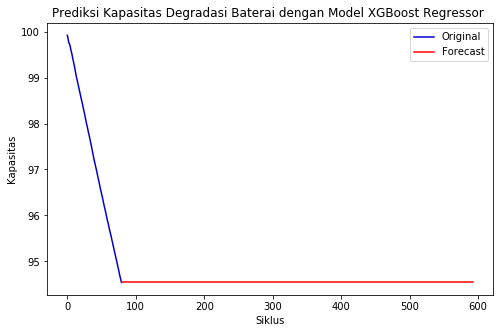

In [123]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(alldata.index[:80], alldata[0][:80], data=alldata, ax=ax, 
             label='Original', color='mediumblue')
sns.lineplot(alldata.index[80:], alldata['Forecast'][80:], data=alldata, ax=ax, 
             label='Forecast', color='red')

ax.set(xlabel = "Siklus",
       ylabel = "Kapasitas",
       title = "Prediksi Kapasitas Degradasi Baterai dengan Model XGBoost Regressor ")



In [124]:
jumlah_cycle = 80
mse = mean_squared_error(forecast, series['Capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])
rmse = np.sqrt(mse)
mae = mean_absolute_error(forecast, series['Capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])
r2 = r2_score(forecast, series['Capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])

In [125]:
rmse, mae, r2

(8.429438018132526, 7.008910250319095, 0.0)

In [58]:
(10.698339791730206, 9.399841813659599, -491578223995.44293)
(8.429438018132526, 7.008910250319095, 0.0)
(11.75381220848739, 10.585587052917411, -263715003343.79022)

(8.429438018132526, 7.008910250319095, 0.0)

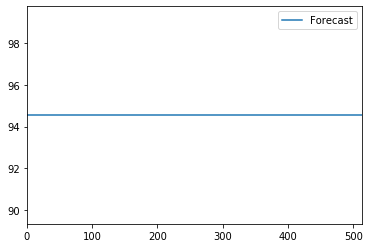

In [21]:
forecast.plot()

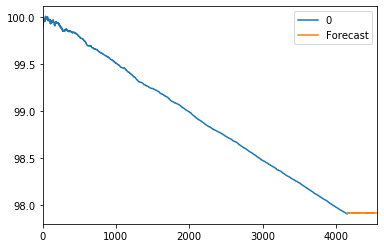

In [252]:
alldata.plot()

In [22]:
dt = DecisionTreeRegressor(max_depth=4)

In [23]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [24]:
forecast_set = dt.predict(X_test)

In [111]:
forecast_set.shape

(514,)

In [25]:
forecast = pd.DataFrame(forecast_set, columns = ['Forecast'])

In [26]:
alldata = pd.concat([model_df['Real'][:80], forecast], ignore_index=True)

[Text(0, 0.5, 'Kapasitas'),
 Text(0.5, 0, 'Siklus'),
 Text(0.5, 1.0, 'Prediksi Kapasitas Degradasi Baterai dengan Model DecisionTreeRegressor ')]

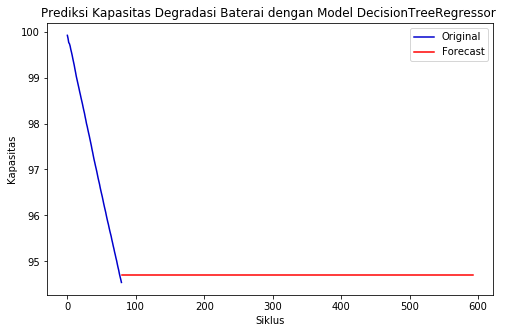

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(alldata.index[:80], alldata[0][:80], data=alldata, ax=ax, 
             label='Original', color='mediumblue')
sns.lineplot(alldata.index[80:], alldata['Forecast'][80:], data=alldata, ax=ax, 
             label='Forecast', color='red')

ax.set(xlabel = "Siklus",
       ylabel = "Kapasitas",
       title = "Prediksi Kapasitas Degradasi Baterai dengan Model DecisionTreeRegressor ")

In [31]:
export_graphviz(dt, out_file = 'dtforecasting.dot')

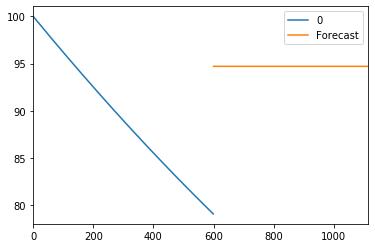

In [114]:
alldata.plot()

In [261]:
regm = svm.SVR()

In [262]:
regm.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [263]:
forecast_set = regm.predict(X_lately)

In [264]:
forecast_set.shape

(414,)

In [266]:
forecast = pd.DataFrame(forecast_set, columns = ['Forecast'])

In [267]:
alldata = pd.concat([series['Capacity'], forecast], ignore_index=True)

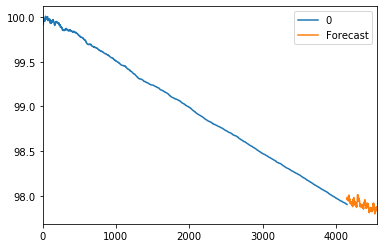

In [268]:
alldata.plot()

In [96]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [97]:
mod = RandomForestRegressor(max_depth=best_params["max_depth"], 
                            n_estimators=best_params["n_estimators"],random_state=False, verbose=False)

In [98]:
mod.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=False,
                      verbose=False, warm_start=False)

In [99]:
forecast_set = mod.predict(X_test)

In [100]:
forecast_set.shape

(514,)

In [101]:
forecast = pd.DataFrame(forecast_set, columns = ['Forecast'])

In [102]:
alldata = pd.concat([model_df['Real'][:80], forecast], ignore_index=True)

[Text(0, 0.5, 'Kapasitas'),
 Text(0.5, 0, 'Siklus'),
 Text(0.5, 1.0, 'Prediksi Kapasitas Degradasi Baterai dengan Model RandomForestRegressor ')]

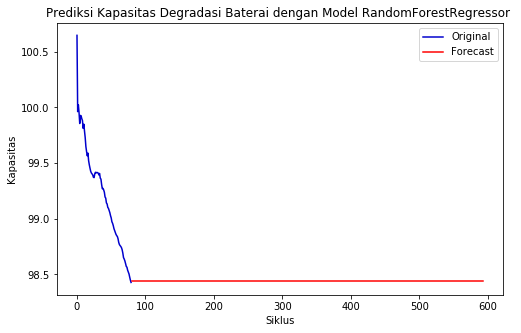

In [103]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(alldata.index[:80], alldata[0][:80], data=alldata, ax=ax, 
             label='Original', color='mediumblue')
sns.lineplot(alldata.index[80:], alldata['Forecast'][80:], data=alldata, ax=ax, 
             label='Forecast', color='red')

ax.set(xlabel = "Siklus",
       ylabel = "Kapasitas",
       title = "Prediksi Kapasitas Degradasi Baterai dengan Model RandomForestRegressor ")

In [104]:
jumlah_cycle = 80
mse = mean_squared_error(forecast, series['Capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])
rmse = np.sqrt(mse)
mae = mean_absolute_error(forecast, series['Capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])
r2 = r2_score(forecast, series['Capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])

In [105]:
rmse, mae, r2

(11.75826124100282, 10.59052686291738, -6.846140552186762e+29)

In [ ]:
(10.699332045201654, 9.400971121963117, -1.4171406024713586e+29)
(8.462740979175615, 7.040259543234301, -3.546350840666094e+29)
(11.75826124100282, 10.59052686291738, -6.846140552186762e+29)

In [278]:
clf = LinearRegression(n_jobs=-1)

In [279]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [280]:
confidence = clf.score(X_test, y_test)

In [281]:
confidence

0.998974040309377

In [282]:
forecast_set = clf.predict(X_lately)

In [283]:
forecast_set.shape

(414,)

In [284]:
forecast_set

array([97.90240452, 97.90128139, 97.90071134, 97.90123759, 97.89963055,
       97.89994255, 97.89875414, 97.89865804, 97.89940554, 97.89856051,
       97.89650884, 97.89742674, 97.89694993, 97.89732693, 97.89681485,
       97.89669027, 97.89624331, 97.89565083, 97.8960138 , 97.89545816,
       97.89537939, 97.89397348, 97.89226355, 97.89200314, 97.8913674 ,
       97.8902087 , 97.88992478, 97.88738481, 97.88784181, 97.88693284,
       97.88752657, 97.88680033, 97.88630574, 97.88562667, 97.88562914,
       97.88493385, 97.88500729, 97.88517406, 97.88609732, 97.88471388,
       97.88481629, 97.88329449, 97.88255972, 97.8825427 , 97.88244834,
       97.88080411, 97.88073154, 97.87967318, 97.87787208, 97.87724381,
       97.87693805, 97.87600929, 97.8759649 , 97.87450289, 97.87476513,
       97.87352176, 97.87315445, 97.87395504, 97.87372058, 97.87175287,
       97.87200789, 97.87133368, 97.87141358, 97.87018737, 97.87029599,
       97.86866447, 97.86897539, 97.86861597, 97.86852562, 97.86

In [285]:
forecast = pd.DataFrame(forecast_set, columns = ['Forecast'])

In [286]:
forecast

,Forecast
0,97.902405
1,97.901281
2,97.900711
3,97.901238
4,97.899631
...,...
409,97.700122
410,97.699828
411,97.698693
412,97.698905


In [287]:
alldata = pd.concat([series['Capacity'], forecast], ignore_index=True)

In [288]:
alldata.shape

(4565, 2)

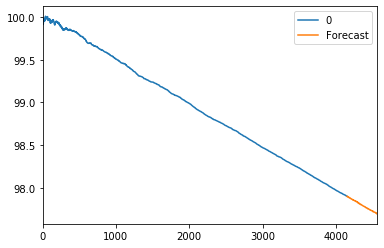

In [289]:
alldata.plot()